In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import re
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

data = pd.read_csv('datasets/songs_cleaned.csv')

2024-05-21 02:33:29.526597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#data = data.sample(frac=0.1)

# Raw Lyric

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 110s 252ms/step - loss: 0.2416 - mean_absolute_error: 0.4226 - val_loss: 0.0972 - val_mean_absolute_error: 0.2533
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 103s 253ms/step - loss: 0.0934 - mean_absolute_error: 0.2486 - val_loss: 0.0719 - val_mean_absolute_error: 0.2227
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 92s 226ms/step - loss: 0.0801 - mean_absolute_error: 0.2328 - val_loss: 0.0677 - val_mean_absolute_error: 0.2175
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 91s 223ms/step - loss: 0.0753 - mean_absolute_error: 0.2266 - val_loss: 0.0653 - val_mean_absolute_error: 0.2145
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 91s 224ms/step - loss: 0.0725 - mean_absolute_error: 0.2232 - val_loss: 0.0639 - val_mean_absolute_error: 0.2125
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 91s 224ms/step - loss: 0.0702 - mean_absolute_error: 0.2200 - val_loss: 0.0628 - val_mean_absolute_error: 0.2110
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 92s 225ms/step - loss: 0.0691 - mean_abs

1398/1398 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0530 - mean_absolute_error: 0.1916
Loss: 0.053, MAE: 0.192


<Axes: >

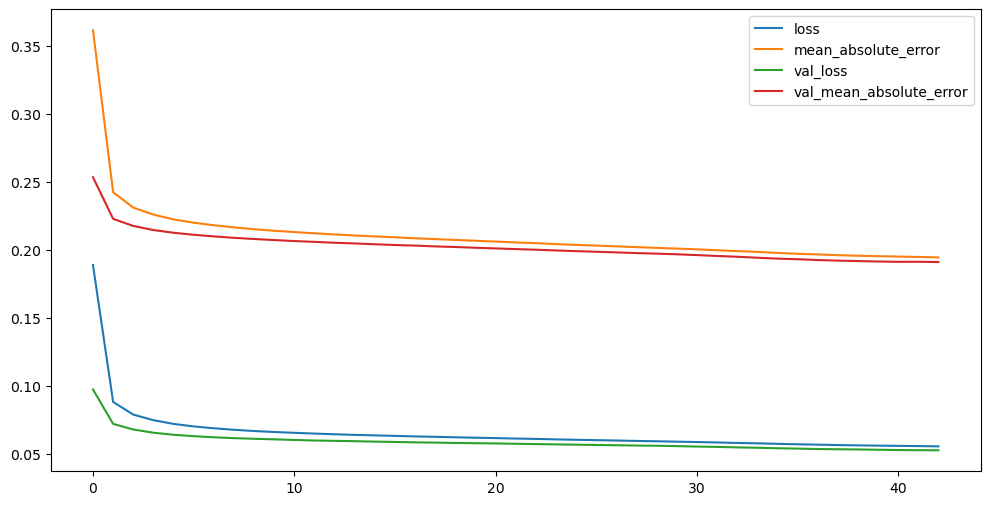

In [3]:
tokenizer = Tokenizer(num_words=1500, oov_token="<OOV>")
tokenizer.fit_on_texts(data['lyric'])
sequences = tokenizer.texts_to_sequences(data['lyric'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, 
                                                  data['valence'], 
                                                  test_size=0.3, 
                                                  random_state=42)

model = Sequential([
    Embedding(input_dim=1500, output_dim=32),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Dense(1, activation='linear') 
])

optimizer = Adam(learning_rate=0.00001)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_absolute_error'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               min_delta=0.001,
                               verbose=1, 
                               mode='min', 
                               restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size = 256,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

loss, mae = model.evaluate(X_val, y_val)
print(f"Loss: {loss:.3f}, MAE: {mae:.3f}")
list_raw_metrics = ["Raw", loss, mae]

pd.DataFrame(history.history).plot(figsize=(12,6))

# Lyric C1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 71s 169ms/step - loss: 0.2216 - mean_absolute_error: 0.3997 - val_loss: 0.0811 - val_mean_absolute_error: 0.2334
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 66s 163ms/step - loss: 0.0826 - mean_absolute_error: 0.2354 - val_loss: 0.0682 - val_mean_absolute_error: 0.2178
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 66s 161ms/step - loss: 0.0748 - mean_absolute_error: 0.2259 - val_loss: 0.0650 - val_mean_absolute_error: 0.2139
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 65s 160ms/step - loss: 0.0716 - mean_absolute_error: 0.2220 - val_loss: 0.0634 - val_mean_absolute_error: 0.2116
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - loss: 0.0694 - mean_absolute_error: 0.2188 - val_loss: 0.0623 - val_mean_absolute_error: 0.2100
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 64s 158ms/step - loss: 0.0681 - mean_absolute_error: 0.2170 - val_loss: 0.0616 - val_mean_absolute_error: 0.2087
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 64s 158ms/step - loss: 0.0664 - mean_absol

<Axes: >

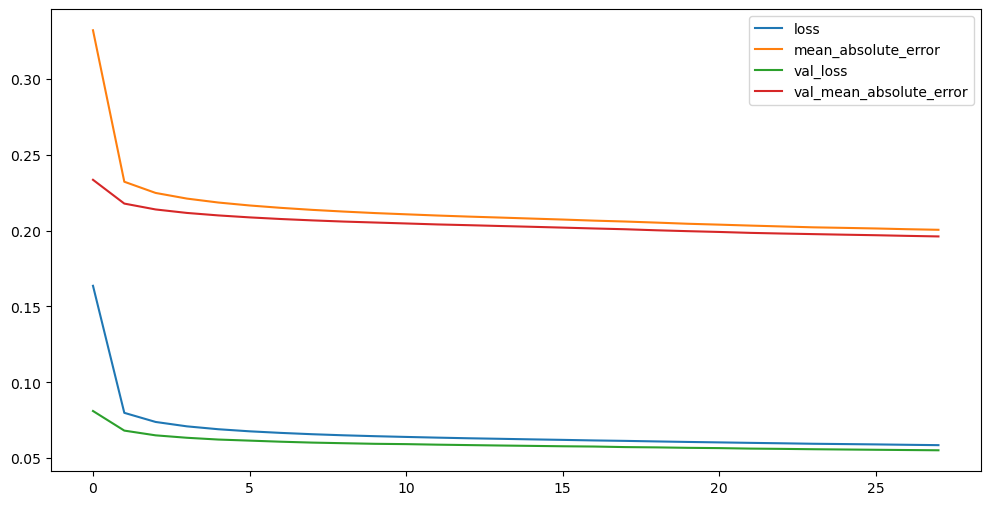

In [4]:
# 0.1920
# Loss: 0.06, MAE: 0.20, MSE: 0.06 
# Loss: 0.060, MAE: 0.207, MSE: 0.060 (300 maxlen)
# Loss: 0.054, MAE: 0.195, MSE: 0.054 (400 maxlen)
# Preprocessing
tokenizer = Tokenizer(num_words=1500, oov_token="<OOV>")
tokenizer.fit_on_texts(data['lyric_clean_1'])
sequences = tokenizer.texts_to_sequences(data['lyric_clean_1'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, 
                                                  data['valence'], 
                                                  test_size=0.3, 
                                                  random_state=42)

model = Sequential([
    Embedding(input_dim=1500, output_dim=32),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Dense(1, activation='linear') 
])

optimizer = Adam(learning_rate=0.00001)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_absolute_error'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               min_delta=0.001,
                               verbose=1, 
                               mode='min', 
                               restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size = 256,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

loss, mae = model.evaluate(X_val, y_val)
print(f"Loss: {loss:.3f}, MAE: {mae:.3f}")
list_c1_metrics = ["C1", loss, mae]

pd.DataFrame(history.history).plot(figsize=(12,6))

# Lyric C2

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 65s 155ms/step - loss: 0.2419 - mean_absolute_error: 0.4227 - val_loss: 0.1003 - val_mean_absolute_error: 0.2571
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - loss: 0.0939 - mean_absolute_error: 0.2491 - val_loss: 0.0695 - val_mean_absolute_error: 0.2196
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - loss: 0.0778 - mean_absolute_error: 0.2295 - val_loss: 0.0660 - val_mean_absolute_error: 0.2152
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step - loss: 0.0740 - mean_absolute_error: 0.2252 - val_loss: 0.0642 - val_mean_absolute_error: 0.2129
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 154ms/step - loss: 0.0709 - mean_absolute_error: 0.2209 - val_loss: 0.0630 - val_mean_absolute_error: 0.2112
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 154ms/step - loss: 0.0692 - mean_absolute_error: 0.2187 - val_loss: 0.0622 - val_mean_absolute_error: 0.2100
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 154ms/step - loss: 0.0680 - mean_absol

<Axes: >

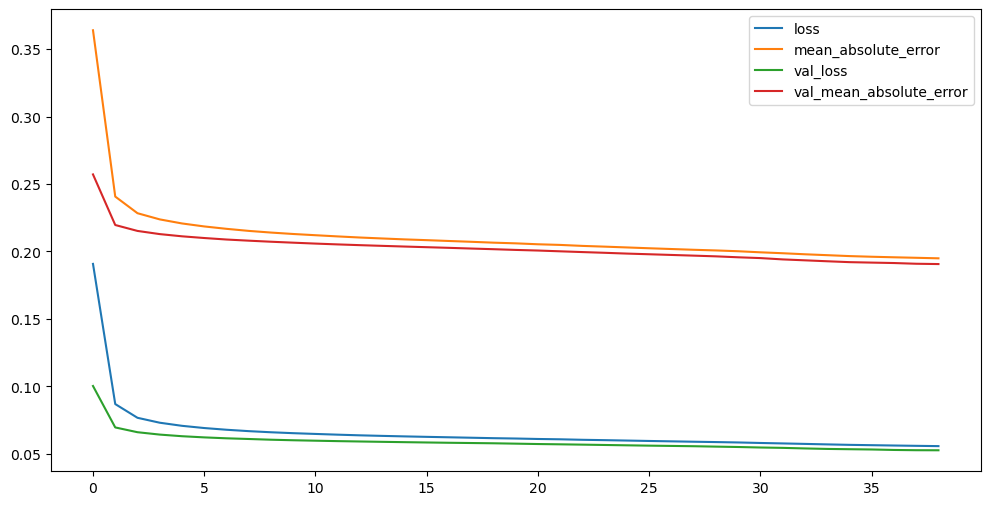

In [5]:
tokenizer = Tokenizer(num_words=1500, oov_token="<OOV>")
tokenizer.fit_on_texts(data['lyric_clean_2'])
sequences = tokenizer.texts_to_sequences(data['lyric_clean_2'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, 
                                                  data['valence'], 
                                                  test_size=0.3, 
                                                  random_state=42)

model = Sequential([
    Embedding(input_dim=1500, output_dim=32),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Dense(1, activation='linear') 
])

optimizer = Adam(learning_rate=0.00001)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_absolute_error'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               min_delta=0.001,
                               verbose=1, 
                               mode='min', 
                               restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size = 256,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

loss, mae = model.evaluate(X_val, y_val)
print(f"Loss: {loss:.3f}, MAE: {mae:.3f}")
list_c2_metrics = ["C2", loss, mae]

pd.DataFrame(history.history).plot(figsize=(12,6))

# Lyric C3

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 70s 165ms/step - loss: 0.2130 - mean_absolute_error: 0.3881 - val_loss: 0.1045 - val_mean_absolute_error: 0.2636
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 68s 166ms/step - loss: 0.1022 - mean_absolute_error: 0.2605 - val_loss: 0.0757 - val_mean_absolute_error: 0.2273
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 68s 166ms/step - loss: 0.0822 - mean_absolute_error: 0.2351 - val_loss: 0.0675 - val_mean_absolute_error: 0.2169
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 68s 167ms/step - loss: 0.0747 - mean_absolute_error: 0.2256 - val_loss: 0.0640 - val_mean_absolute_error: 0.2120
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 68s 167ms/step - loss: 0.0714 - mean_absolute_error: 0.2215 - val_loss: 0.0625 - val_mean_absolute_error: 0.2100
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 64s 156ms/step - loss: 0.0693 - mean_absolute_error: 0.2186 - val_loss: 0.0615 - val_mean_absolute_error: 0.2088
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step - loss: 0.0683 - mean_absol

<Axes: >

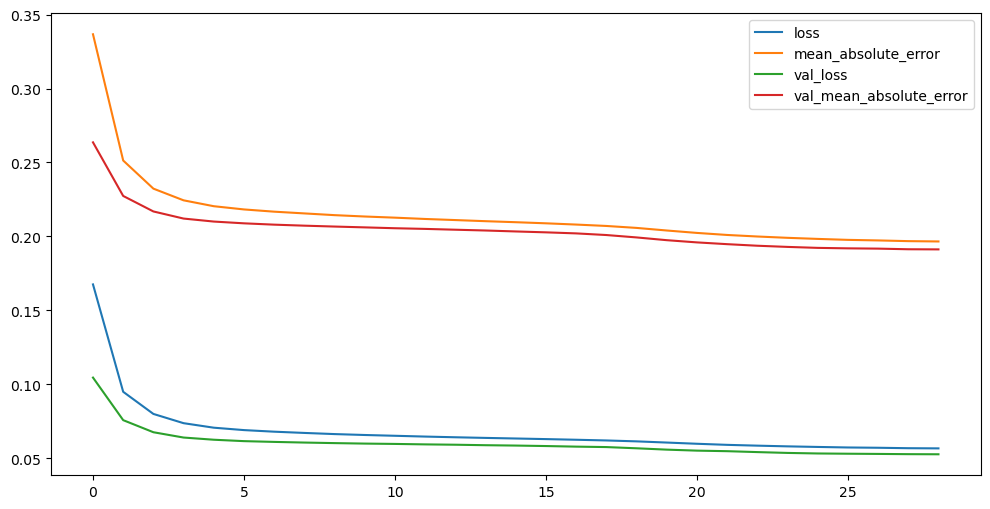

In [6]:
tokenizer = Tokenizer(num_words=1500, oov_token="<OOV>")
tokenizer.fit_on_texts(data['lyric_clean_3'])
sequences = tokenizer.texts_to_sequences(data['lyric_clean_3'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, 
                                                  data['valence'], 
                                                  test_size=0.3, 
                                                  random_state=42)

model = Sequential([
    Embedding(input_dim=1500, output_dim=32),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Dense(1, activation='linear') 
])

optimizer = Adam(learning_rate=0.00001)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_absolute_error'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               min_delta=0.001,
                               verbose=1, 
                               mode='min', 
                               restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size = 256,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

loss, mae = model.evaluate(X_val, y_val)
print(f"Loss: {loss:.3f}, MAE: {mae:.3f}")
list_c3_metrics = ["C3", loss, mae]

pd.DataFrame(history.history).plot(figsize=(12,6))

# Lyric C4

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 66s 155ms/step - loss: 0.2095 - mean_absolute_error: 0.3847 - val_loss: 0.1081 - val_mean_absolute_error: 0.2682
Epoch 2/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 154ms/step - loss: 0.1038 - mean_absolute_error: 0.2625 - val_loss: 0.0774 - val_mean_absolute_error: 0.2297
Epoch 3/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step - loss: 0.0830 - mean_absolute_error: 0.2362 - val_loss: 0.0688 - val_mean_absolute_error: 0.2186
Epoch 4/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step - loss: 0.0754 - mean_absolute_error: 0.2267 - val_loss: 0.0646 - val_mean_absolute_error: 0.2131
Epoch 5/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step - loss: 0.0710 - mean_absolute_error: 0.2208 - val_loss: 0.0628 - val_mean_absolute_error: 0.2107
Epoch 6/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 154ms/step - loss: 0.0694 - mean_absolute_error: 0.2191 - val_loss: 0.0620 - val_mean_absolute_error: 0.2095
Epoch 7/50
408/408 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step - loss: 0.0681 - mean_absol

<Axes: >

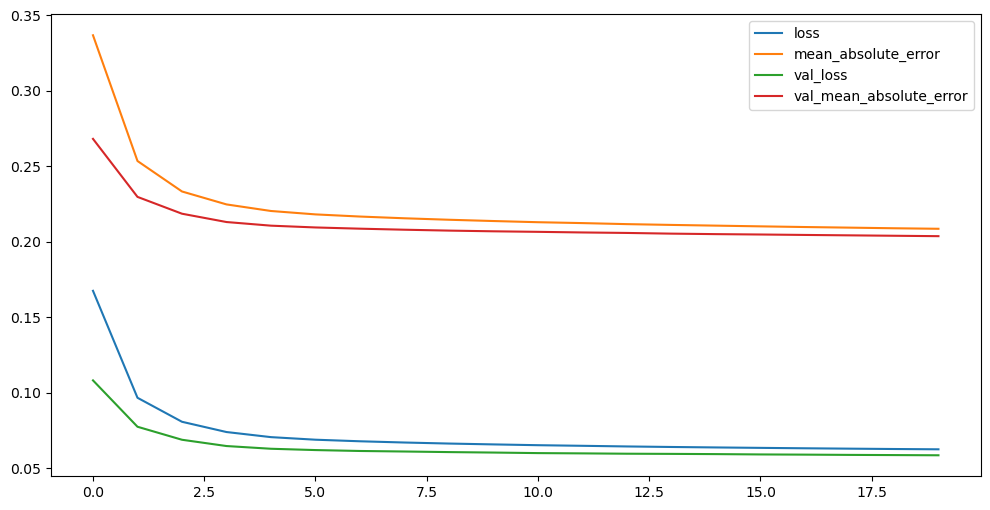

In [7]:
tokenizer = Tokenizer(num_words=1500, oov_token="<OOV>")
tokenizer.fit_on_texts(data['lyric_clean_4'])
sequences = tokenizer.texts_to_sequences(data['lyric_clean_4'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, 
                                                  data['valence'], 
                                                  test_size=0.3, 
                                                  random_state=42)

model = Sequential([
    Embedding(input_dim=1500, output_dim=32),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Dense(1, activation='linear') 
])

optimizer = Adam(learning_rate=0.00001)

model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=['mean_absolute_error'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               min_delta=0.001,
                               verbose=1, 
                               mode='min', 
                               restore_best_weights=True)

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size = 256,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

loss, mae = model.evaluate(X_val, y_val)
print(f"Loss: {loss:.3f}, MAE: {mae:.3f}")
list_c4_metrics = ["C4", loss, mae]

pd.DataFrame(history.history).plot(figsize=(12,6))

In [8]:
list_metrics = [list_raw_metrics, list_c1_metrics, list_c2_metrics, list_c3_metrics, list_c4_metrics]

df_metrics = pd.DataFrame(list_metrics, columns =['Type', 'Loss', 'MAE'])
print(df_metrics)


  Type      Loss       MAE
0  Raw  0.053202  0.191975
1   C1  0.056119  0.198030
2   C2  0.053598  0.192732
3   C3  0.053548  0.192884
4   C4  0.059298  0.205044
